In [24]:
import numpy as np
import scipy as scp
from pyedflib import highlevel
import pyedflib as plib
import matplotlib.pyplot as plt
import mne as mne
import os

In [25]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


#subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
subfolders, datafiles = run_fast_scandir('../dataset/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])

['../dataset/files\\S001', '../dataset/files\\S002', '../dataset/files\\S003']
['../dataset/files\\S001\\S001R01.edf', '../dataset/files\\S001\\S001R02.edf', '../dataset/files\\S001\\S001R03.edf']


<h1>Criação do filter bank - próximos 2 blocos</h1>

In [26]:
min_freq = 4
max_freq = 40

n_bands = int((max_freq - min_freq)/2)

bands = []
f1 = 4
f2 = 8

for i in range(1,n_bands):
  bands.append([f1,f2])
  f1+=2
  f2+=2
print("Bandas de frequência: ", bands)

Bandas de frequência:  [[4, 8], [6, 10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]


In [27]:
mne.set_log_level('INFO') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

filter_design = 'firwin2'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)
channels = raw.ch_names
n_channels = len(channels)

for band in bands:

  filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=band[0], h_freq=band[1], fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
  #mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.5, 60)) # Plot do filtro

mne.set_log_level('WARNING')

Extracting EDF parameters from c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\dataset\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 529 samples (3.306 s)

Setting up band-pass filter from 6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper pass

In [28]:
def check_event_count(event_data):

  '''
  Função que:
  - Faz prints do número de trials/blocos de cada classe de movimento. 

  ---------------------
  Input:
  - event_data: Objeto com todos os blocos de dados

  '''

  print("Rest: ", event_data["rest"].__len__())
  print("Right Fist: ", event_data["right_fist"].__len__())
  print("Left Fist: ", event_data["left_fist"].__len__())
  print("Both Fists: ", event_data["both_fists"].__len__())
  print("Both Feet: ", event_data["both_feet"].__len__())
     

''' Commit "Test/Train split: 84144ec" tem todo o código com os prints e plots desta função relacionados com os eventos'''

def load_subject_data(subject, datafiles, bands, tstart, tstop):

  '''
  Função que:
  - Carrega todos os dados contínuos de um participante da base de dados.
  - Filtra os dados contínuos.
  - Reatribui as labels para separar melhor as 5 classes de EEG da base de dados.
  - Agrupa e concatena os blocos dados dos vários trials (bloco com cerca de 4.2s de dados que 
  corresponde à execução de uma classe de movimento) de ficheiros 
  diferentes a partir das novas labels.
  - Segmenta os dados 

  ---------------------
  Input:
  subject: Caminho para o diretório onde estão todos os ficheiros de um participante 
  datafiles: Caminhos de todos os ficheiros edf (todos os participantes) da base de dados
  tstart: Instante no tempo (s) da primeira amostra do segmento de um bloco a ser analisado
  tstop: Instante no tempo (s) da última amostra do segmento de um bloco a ser analisado
  
  ---------------------
  Output:
  subject_epochs: Objeto com todos os blocos de dados concatenados e com toda a informção relativamente
  aos eventos de cada classe
  '''

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)

  eachBand_epochs = []
  
  for band in bands: # Filtrar os dados nas várias bandas de frequência
    print(f"Filtragem na banda de frequências: {band[0]} - {band[1]} Hz")

    all_trials = [] # Variável com todos os blocos
    
    for count, trial  in enumerate(trials):
      if count > 1: # Avança os dois primeiros trials correspondentes ao rest
        raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
        
        ch_names = raw_data.ch_names # Elétrodos
        fs =  raw_data.info.get('sfreq') # Frequência de amostragem
        annotations = raw_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados

        trial_type1 = [3, 4, 7, 8, 11, 12]
        trial_type2 = [5, 6, 9, 10, 13, 14]

        # Atribuição das labels corretas aos eventos de cada trial
        #--------------- TOMÁS: tive de adaptar a linha seguinte por causa da maneira como tenho o diretório (../ yada yada, cria uma separação para cada ponto,
        # então fica algo tipo [''] [''] ['actual diretorio'] ['edf']) -----------------------------------------
        trial_number = int(trial.split('.')[2][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
        
        if trial_number in trial_type1:
          event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
          epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
        elif trial_number in trial_type2:
          event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
          epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
        else:
          event_ids = {'T0': 1} # Dois primeiros trials de EEG

        # Filtragem

        filtered_data = raw_data.copy().filter(band[0], band[1], fir_design=filter_design, skip_by_annotation=ska) 
        
        # Mapeamento dos eventos com as novas labels

        events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
        
        # Agrupamento dos blocos do mesmo id (epoching)

        epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = tstart, tmax = tstop, detrend = 1, baseline = None, preload = True)
        
        all_trials.append(epochs)
        
    # Concatenação de todos os blocos (trials) de uma banda de frequências

    subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')
    equalized_subject_epochs = subject_epochs.equalize_event_counts()[0]

    eachBand_epochs.append(equalized_subject_epochs)
    
  return eachBand_epochs

In [29]:
# Carregar dados de todos os participantes
# Equaliza o nº de trials em todas as classes. A classe rest tinha muitos mais trials por exemplo.
# O bom balanceamento de classes é importante durante a classificação

mne.set_log_level('CRITICAL')

all_subject_epochs = []

for id, subject in enumerate(subfolders[0:2]):
  print("---------------------------------------------")
  print("Ler dados do participante: ", id+1)
  all_subject_epochs.append(load_subject_data(subject, datafiles, bands, 0.5, 3))

mne.set_log_level('WARNING')

---------------------------------------------
Ler dados do participante:  1
Filtragem na banda de frequências: 4 - 8 Hz
Filtragem na banda de frequências: 6 - 10 Hz
Filtragem na banda de frequências: 8 - 12 Hz
Filtragem na banda de frequências: 10 - 14 Hz
Filtragem na banda de frequências: 12 - 16 Hz
Filtragem na banda de frequências: 14 - 18 Hz
Filtragem na banda de frequências: 16 - 20 Hz
Filtragem na banda de frequências: 18 - 22 Hz
Filtragem na banda de frequências: 20 - 24 Hz
Filtragem na banda de frequências: 22 - 26 Hz
Filtragem na banda de frequências: 24 - 28 Hz
Filtragem na banda de frequências: 26 - 30 Hz
Filtragem na banda de frequências: 28 - 32 Hz
Filtragem na banda de frequências: 30 - 34 Hz
Filtragem na banda de frequências: 32 - 36 Hz
Filtragem na banda de frequências: 34 - 38 Hz
Filtragem na banda de frequências: 36 - 40 Hz
---------------------------------------------
Ler dados do participante:  2
Filtragem na banda de frequências: 4 - 8 Hz
Filtragem na banda de freq

<h1>Exemplo de handling destes dados


Equalização de eventos: 
Rest:  44
Right Fist:  44
Left Fist:  44
Both Fists:  44
Both Feet:  44


Indices:  [ 8 10 12]
Condições:  {'rest/block': 1, 'left_fist/block': 2, 'right_fist/block': 3, 'both_fists/block': 4, 'both_feet/block': 5}

Blocos:  [[   672      0      3]
 [  1328      0      1]
 [  2000      0      2]
 [  3328      0      2]
 [  4656      0      3]
 [  5312      0      1]
 [  5984      0      3]
 [  6640      0      1]
 [  7312      0      2]
 [  8640      0      2]
 [  9968      0      3]
 [ 10624      0      1]
 [ 11296      0      2]
 [ 12624      0      3]
 [ 13280      0      1]
 [ 13952      0      3]
 [ 14608      0      1]
 [ 15280      0      2]
 [ 17936      0      3]
 [ 18592      0      1]
 [ 19264      0      2]
 [ 22016      0      3]
 [ 22672      0      1]
 [ 23344      0      2]
 [ 24672      0      2]
 [ 26000      0      3]
 [ 26656      0      1]
 [ 27328      0      3]
 [ 27984      0      1]
 [ 28656      0      2]
 [ 29984      0      3]
 [ 30

C:\Users\tomas\AppData\Local\Temp\ipykernel_2088\4045588460.py:14: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  subject_epochs["right_fist"].plot_image(picks=[chan[0]])


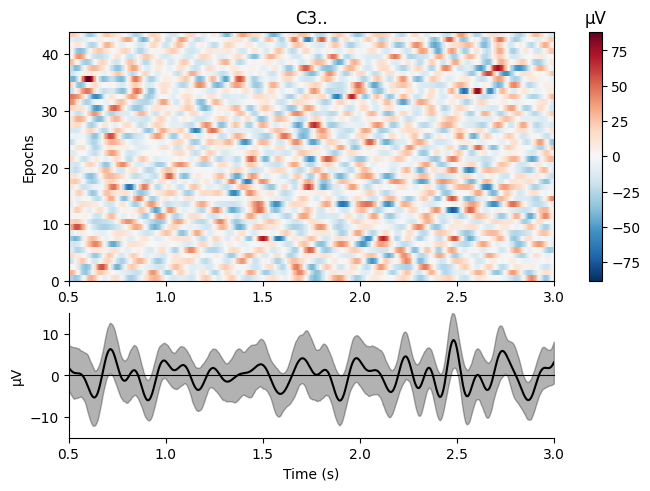

[<Figure size 640x480 with 3 Axes>]

In [30]:
subject_epochs = all_subject_epochs[0][0]

print("\nEqualização de eventos: ")
check_event_count(subject_epochs)
print("\n")

# Seleção de elétrodos
chan = mne.pick_channels(channels, include = ['C3..','Cz..','C4..'])
print("Indices: ", chan)

#dir(subject_epochs)
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[chan[0]])

<h2> Função que vem a seguir, antes do csp, avalia se achas necessario/ se da jeito

In [31]:
def split_EEG(subject_EEG, classes, percent_train=0.8):
  
  n_trials, _, _ = np.shape(subject_EEG)
  n_train = round((n_trials/len(classes)) * percent_train)
  n_test = int((n_trials/len(classes)) - n_train)

  print("Nº de trials: ", n_trials)
  print("Nº de trials para treinar (por classe): ", n_train)
  print("Nº de trials para teste (por classe): ", n_test)

  epochs_train = []
  epochs_test = []

  for class_key, _ in classes.items():
    epochs_train.append(subject_EEG[class_key][:n_train])
    epochs_test.append(subject_EEG[class_key][n_train:n_train+n_test])
  
  epochs_train = mne.concatenate_epochs(epochs_train, add_offset = True, on_mismatch = 'raise')
  epochs_test = mne.concatenate_epochs(epochs_test, add_offset = True, on_mismatch = 'raise')

  return epochs_train, epochs_test

# Split Test/Train

classes = subject_epochs.event_id

all_train_data = []
all_test_data = []

for subject in range(len(all_subject_epochs)):

  bands_train_data = []
  bands_test_data = []
  print("Sujeito: ", subject+1)

  for band in range(len(bands)):
    train_data, test_data = split_EEG(all_subject_epochs[subject][band], classes, percent_train=0.8)
    bands_train_data.append(train_data)
    bands_test_data.append(test_data)

  all_train_data.append(bands_train_data)
  all_test_data.append(bands_test_data)

Sujeito:  1
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
Nº de trials:  220
Nº de trials para treinar (por cl